# Handwritten Digit Recognizer

Note: This notebook is desinged to run with CPU (no GPU) runtime.

####[HDR-01]
Import modules.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, saving

####[HDR-02]
Mount your Google Drive on `/content/gdrive`.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


####[HDR-03]
Confirm that the exported model file `MNIST_double.hd5` is on your Google Drive.

In [3]:
!ls -lh '/content/gdrive/My Drive/MNIST_double.keras'

-rw------- 1 root root 38M Feb 16 03:51 '/content/gdrive/My Drive/MNIST_double.keras'


####[HDR-04]
Restore the model from the exported model file.

In [4]:
model = saving.load_model('/content/gdrive/My Drive/MNIST_double.keras')
model.summary()

Model: "CNN_double_layer_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_filter1 (Conv2D)                │ (None, 28, 28, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1 (MaxPooling2D)          │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_filter2 (Conv2D)                │ (None, 14, 14, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2 (MaxPooling2D)          │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden (Dense)                       │ (None, 1024)                │       3,212,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (Dense)                      │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,823,904 (37.48 MB)

 Trainable params: 3,274,634 (12.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,549,270 (24.98 MB)

####[HDR-05]
Define a model to extract outputs from intermediate layers.

In [5]:
layer_outputs = [model.get_layer('max_pooling1').output,
                 model.get_layer('max_pooling2').output]
model2 = models.Model(inputs=model.inputs[0], outputs=layer_outputs)

####[HDR-06]
Define a Javascript function to create a drawing canvas.

In [6]:
input_form = """
<table>
<td style="border-style: none;">
<div style="border: solid 2px #666; width: 143px; height: 144px;">
<canvas width="140" height="140"></canvas>
</div></td>
<td style="border-style: none;">
<button onclick="clear_value()">Clear</button>
</td>
</table>
"""

javascript = """
<script type="text/Javascript">
    var pixels = [];
    for (var i = 0; i < 28*28; i++) pixels[i] = 0;
    var click = 0;

    var canvas = document.querySelector("canvas");
    canvas.addEventListener("mousemove", function(e) {
        if (e.buttons == 1) {
            click = 1;
            canvas.getContext("2d").fillStyle = "rgb(0, 0, 0)";
            canvas.getContext("2d").fillRect(e.offsetX, e.offsetY, 8, 8);
            x = Math.floor(e.offsetY*0.2);
            y = Math.floor(e.offsetX*0.2) + 1;
            for (var dy = 0; dy < 2; dy++) {
                for (var dx = 0; dx < 2; dx++) {
                    if ((x + dx < 28) && (y + dy < 28)) {
                        pixels[(y+dy)+(x+dx)*28] = 1;
                    }
                }
            }
        } else {
            if (click == 1) set_value()
            click = 0;
        }
    });

    function set_value() {
        var result = "";
        for (var i = 0; i < 28*28; i++) result += pixels[i] + ",";
        google.colab.kernel.invokeFunction(
                          'notebook.set_image', [result], {});
    }

    function clear_value() {
        canvas.getContext("2d").fillStyle = "rgb(255, 255, 255)";
        canvas.getContext("2d").fillRect(0, 0, 140, 140);
        for (var i = 0; i < 28*28; i++) pixels[i] = 0;
    }
</script>
"""

####[HDR-07]
Show a drawing canvas.

In [7]:
from google.colab import output
from IPython.display import HTML

def set_image(result):
    global image
    image = np.array([float(x) for x in result.split(',')[:-1]])

image = None
output.register_callback('notebook.set_image', set_image)

HTML(input_form + javascript)

####[HDR-08]
Make a prediction for the handwritten digit on the drawing canvas.

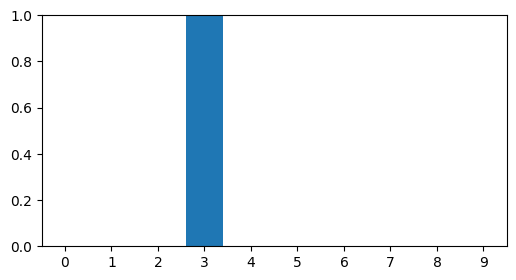

In [12]:
p_val = model.predict(image.reshape(1, 28*28), verbose=0)

fig = plt.figure(figsize=(6, 3))
pred = p_val[0]
subplot = fig.add_subplot(1, 1, 1)
subplot.set_xticks(range(10))
subplot.set_xlim(-0.5, 9.5)
subplot.set_ylim(0, 1)
_ = subplot.bar(range(10), pred, align='center')

####[HDR-09]
Get output images from the convolutional filters.

In [13]:
pool1_output, pool2_output = model2.predict(image.reshape(1, 28*28))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


####[HDR-10]
Show output images from the first pooling layer.

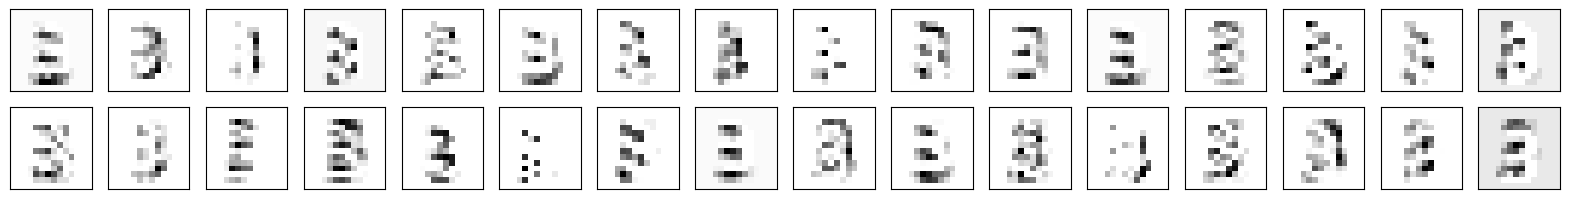

In [14]:
layer = pool1_output
fig = plt.figure(figsize=(20, 10))
for i in range(layer.shape[-1]):
    subplot = fig.add_subplot(8, 16, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(layer[0, :, :, i], cmap=plt.cm.gray_r)

####[HDR-11]
Show output images from the second pooling layer.

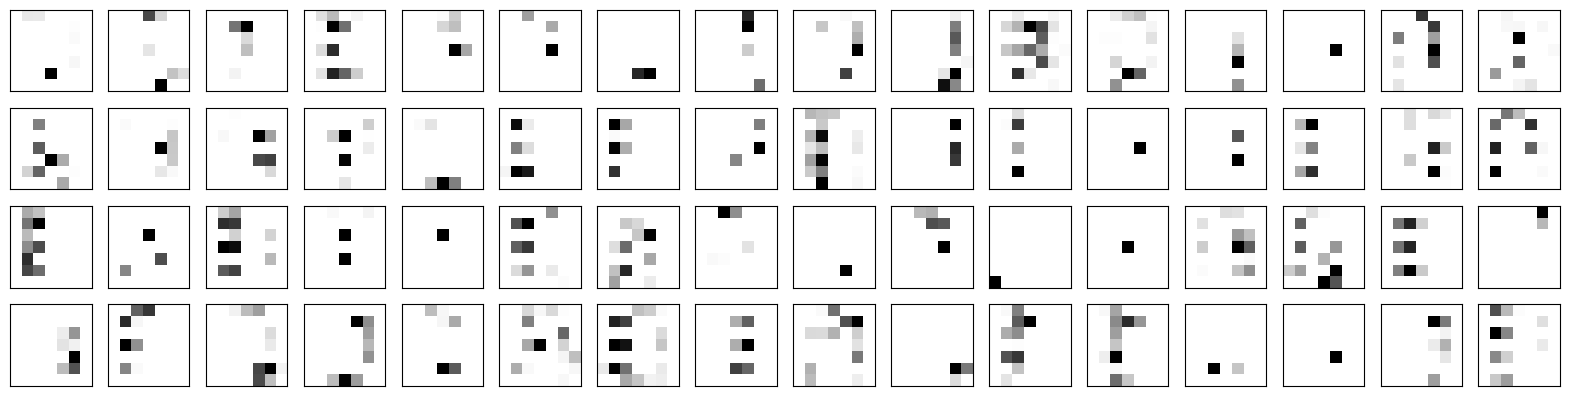

In [15]:
layer = pool2_output
fig = plt.figure(figsize=(20, 10))
for i in range(layer.shape[-1]):
    subplot = fig.add_subplot(8, 16, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(layer[0, :, :, i], cmap=plt.cm.gray_r)